<a href="https://colab.research.google.com/github/snxly/colab/blob/master/zero2hero_bigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API in Python
- open('name.text','r').read().splitlines()
- len
- min/max
- zip
- list
- sorted
- set
- enumerate
- print
- list
  - append

# API in Pytorch.tensor
- torch.zeros
- torch.multinomial
- torch.Generator
- torch.multimomial
- torch.sum(input, axis, keepdim)
- broadcast sementic
- torch.tensor

# API in torch.nn.functional
- one_hot(index, total)


# API in matplotlib
- plt.figure(figsize=(16,16))
- plt.imshow(counts, cmap='Blues')
- plt.text

# Model

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-08-02 03:54:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-08-02 03:54:41 (6.07 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
#load words
words = open('names.txt','r').read().splitlines()

In [ ]:
# 生成 chars - index 互转的 map， s2i and i2s
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
# 统计任意两个字母共现的个数，保存在二维数组中
import torch
counts = torch.zeros((27,27), dtype=torch.int32)

# get counts for every two-character-combination
for w in words:
  w = '.'+w+'.'
  for ch1, ch2 in zip(w, w[1:]):
    i1 = stoi[ch1]
    i2 = stoi[ch2]
    counts[i1, i2] += 1

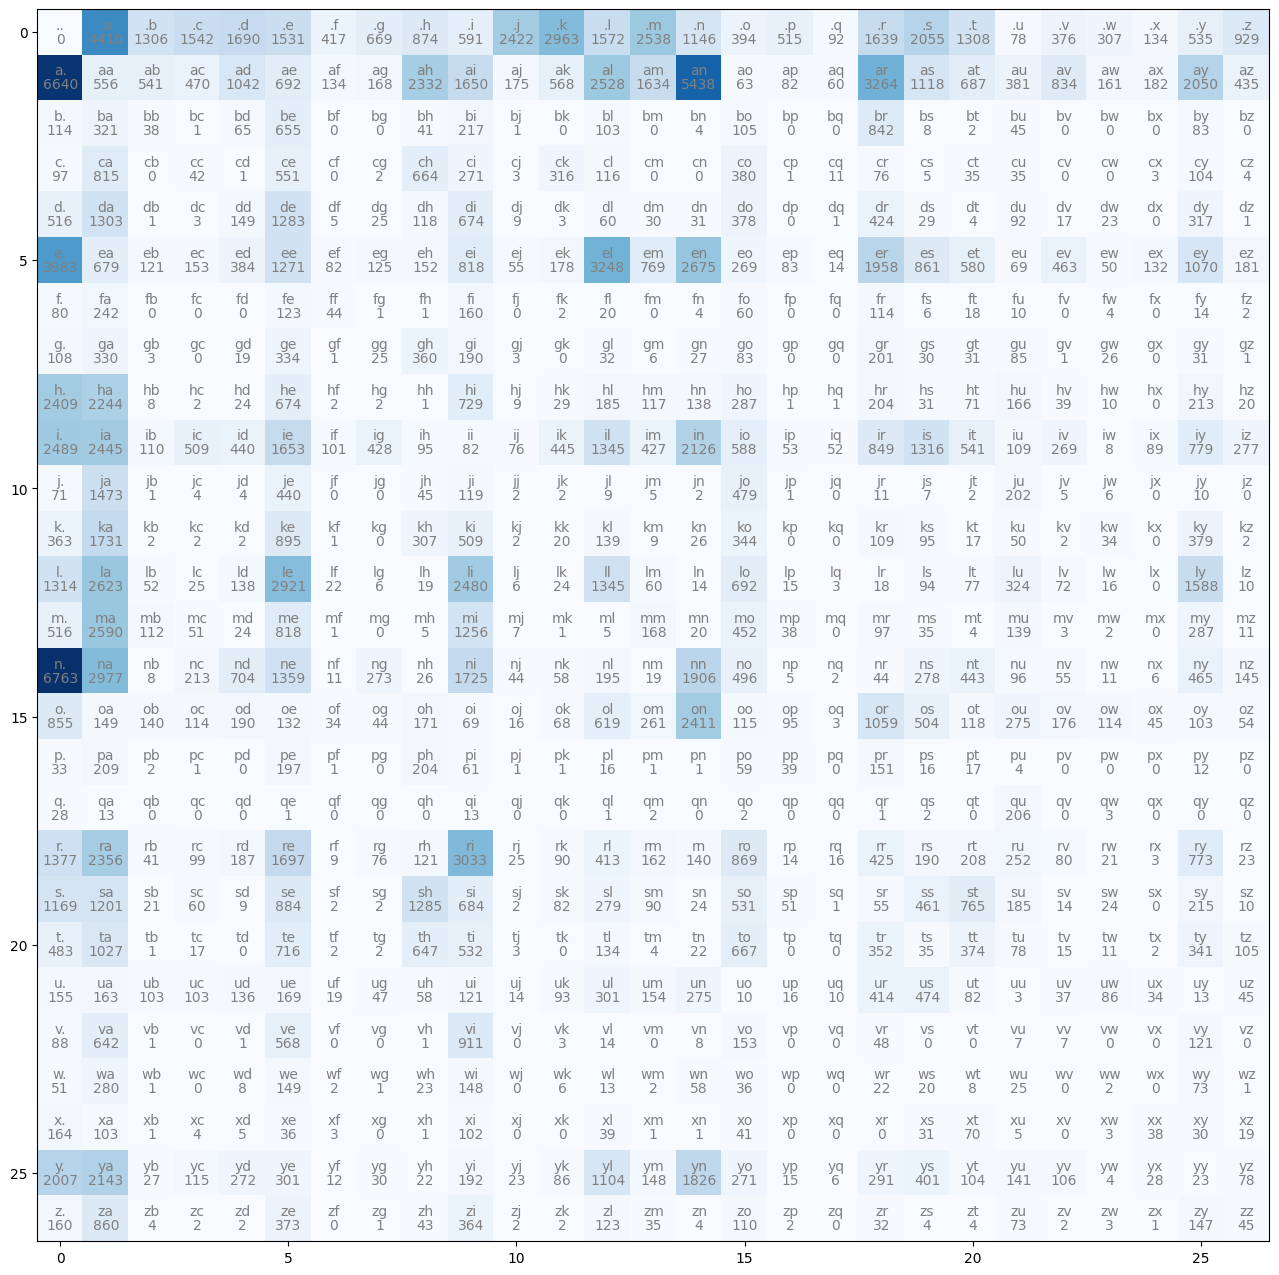

In [ ]:
# 使用matplotlib 可视化 counts 二维数组
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.imshow(counts, cmap='Blues')
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        chstr = itos[i] + itos[j]
        # plt 中使用的是图像坐标系，
        # 第一个参数是水平轴的索引，即列索引
        # 第二个参数是垂直轴的索引，即行索引
        # va='bottom' 应该是让文本的 底部 对齐坐标点，所以文本显示在了上面
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, counts[i, j].item(), ha='center', va='top', color='gray')
plt.show()

# Sample
在二维数组的基础上进行 sample, 即使用这个model做一些产出,生成一些字符串,看看效果

In [ ]:
# pytorch中，generator和 multinomial的使用
# generator
# 一个固定种子的generator，保证每次都生成相同的数据，而非随机数
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p/p.sum()
print(p)
# multinomial
# 根据提供的概率p，返回 index
# replacement的意思是：袋子里按照比例放置了不同颜色的小球，取出一个以后，取下一个之前要不要把第一个放回去
tensor = torch.multinomial(p, num_samples=10, replacement=True, generator=g)

tensor([0.6064, 0.3033, 0.0903])


torch.Size([10])

In [ ]:
# 把counts的每一行都变成概率，最终是一个 （27,1）的tensor
# +1 here is to prevent log(0)
P = (counts + 1).float()
P = P / P.sum(1, keepdim=True)
P[0].sum()
# P[0]

tensor(1.)

In [ ]:
g = torch.Generator().manual_seed(2147483647)

# generate 5 words
for w in range(5):
  idx = 0
  out = []
  while(True):
    # word = ''
    p = P[idx]
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if idx == 0:
      print(''.join(out))
      break
    else:
      out.append(itos[idx])


junide
janasah
p
cony
a


# Evaluate
## 怎样评价一个 model 的效果？
Start From 54:00  
1. likelihood = 所有概率的乘积, too tiny, so
2. log likelihood, turn to negative value,   
概率越低，值越小  
```log(a*b*c) = log(a) + log(b) + log(c)```
3. `Loss`的期望是'值越小，代表越好，即概率越大', 和 `log-likelihood` 是反的。  
因此，我们用 `negative-log-likelihood` 来表示LOSS
4. 由于上面的值是求和得到的，因此最后我们取个平均，这就是我们最终的 Loss Function
## 总结
- 目标是 最大化 likelihood, w.r.t parameters
- 等价于 最大化 log lokelihood, 因为log是单调增函数 (monotonic)
- 等价于 最小化 negative log likelihood
- 等价于 最小化 average negative log likelihood
## 改进
1. prob = 0时, log=INF, 最简单的改进方法是每个item的计数都+1，避免0的出现。


In [ ]:
n = 0
sum = 0
for w in words:
  w = '.'+w+'.'
  for ch1, ch2 in zip(w, w[1:]):
    i1 = stoi[ch1]
    i2 = stoi[ch2]
    p = P[i1, i2]
    logp = torch.log(p)
    # print(f'{ch1, ch2}: {logp:.4f}')
    sum += logp
    n += 1
#negative-log-likelihood
nll = -sum/n
nll

tensor(2.4544)

In [ ]:
# a negative case, where probability = 0
n = 0
sum = 0
for w in ['jq']:
  w = '.'+w+'.'
  for ch1, ch2 in zip(w, w[1:]):
    i1 = stoi[ch1]
    i2 = stoi[ch2]
    p = P[i1, i2]
    logp = torch.log(p)
    print(f'{ch1, ch2}: {logp:.4f}')
    sum += logp
    n += 1
#negative-log-likelihood
nll = -sum/n
nll

('.', 'j'): -2.5826
('j', 'q'): -7.9817
('q', '.'): -2.3331


tensor(4.2992)

# 结论
基于统计结果的Bigram的 `average negative log likelihood` 大约为 2.45


# Bigram的ML实现
只有一个linear layer (xenc @ W), 并且没有 non-linear  
不过参数的size相同，都是 27 * 27

In [ ]:
# 1. setup training set
xs, ys = [], []
for w in words[:1]:
  w = '.'+w+'.'
  for ch1, ch2 in zip(w, w[1:]):
    i1 = stoi[ch1]
    i2 = stoi[ch2]
    xs.append(i1)
    ys.append(i2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [ ]:
# How to feed data into a neural network?
# We need to encode the input, instead of just feed the integer
# one-hot is an option to encode
import torch.nn.functional as F
# change int to float
xenc = F.one_hot(xs, num_classes=27).float()
xenc

torch.float32

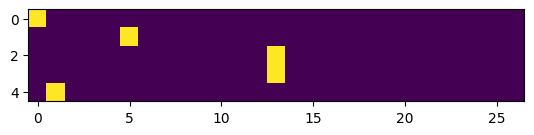

In [ ]:
plt.imshow(xenc)

In [ ]:
# initial w
# we have 27 inputs, to match with the input (one-hot size)
# and we have 27 output, to match with the 27 predictions
w = torch.randn((27,27), requires_grad=True)
# (5, 27) @ (27,27) -> (5,27)
# xenc @ w


In [ ]:
# 观察上面的计算结果，有正有负。我们可以理解为 log(count)
# 所以需要做 exp 来获得真正的 count，为计算概率做准备
logits = (xenc @ w) # log counts
counts = logits.exp() # equivalent with counts
probs = counts / counts.sum(1, keepdims=True)
# probs
# turns out, this is forward pass

In [ ]:
# 计算 loss
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  y = ys[i].item() # label character index
  prob = probs[i, y]
  nll = -torch.log(prob)
  nlls[i] = nll
loss = nlls.mean()
loss

In [ ]:
# 用 pytorch 的方式计算 loss
# ys = [ 5, 13, 13,  1,  0], 所以我们希望获得的probs是
# probs[0, 5], probs[1, 13], probs[2,13], probs[3, 1], probs[4, 0]
# in pytorch way
logits = probs[torch.arange(5), ys]

loss = -logits.log().mean()
# loss
print(loss.item())

3.965574264526367


In [ ]:
# backward pass
# 1. remember to reset all gradients before backward
w.grad = None
# 2. then do backward, be sure to set 'requires_grad=True' for weights
loss.backward()

In [ ]:
# update data
w.data += -0.1 * w.grad

# All-in-One

In [ ]:
# 1. setup training set
xs, ys = [], []
for w in words:
  w = '.'+w+'.'
  for ch1, ch2 in zip(w, w[1:]):
    i1 = stoi[ch1]
    i2 = stoi[ch2]
    xs.append(i1)
    ys.append(i2)

num = len(xs) # number of samples
print('number of examples = ', num)

# turn data into tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# initialize the parameters
W = torch.randn((27,27), requires_grad=True)


number of examples =  228146


In [ ]:
# 2. gradient descent
for i in range(100):
  ## 2.1 forward pass
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  ## 2.2 calculate loss
  loss = -probs[torch.arange(num), ys].log().mean()
  print('loss=', loss)
  ## 2.3 backward pass
  W.grad = None
  loss.backward()
  ## 2.4 update data
  W.data += -50 * W.grad

In [ ]:
# 3. How to sample
g = torch.Generator().manual_seed(2147483647)

# generate 5 words
for w in range(5):
  idx = 0
  out = []
  while(True):
    ### Before
    # p = P[idx]
    ###  Now, we do forward pass to get the prob
    xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)
    ###
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if idx == 0:
      print(''.join(out))
      break
    else:
      out.append(itos[idx])

junide
janasah
prelay
a
nn


# 最后再说两句
1. 由于xenc是one-hot变量，因为 xenc @ W 就相当于从W中取一行出来，这个和我们通过统计的方式取sample是一样的道理。
2. 我们之前为了fix log(0)的问题，解决方式是在每个count上加1。这其实就是一种正则化 regularization。和在loss上加正则表达式 `(0.01 * (W ** 2).mean())` 是一样的道理。